In [1]:
#Used libraries
import csv
import re
import os
from brian2 import *
import numpy as np
from scipy.interpolate import interp1d
import brian2.numpy_ as np
import matplotlib.pyplot as plt
import time
import warnings
from scipy import interpolate
from keras.datasets import mnist
from tqdm import tqdm
import random
import pickle
from random import shuffle
import seaborn as sn
import pandas as pd
import pickle


weight_matrix_exci.shape (784, 1225)
weight_matrix_inhi.shape (784, 1225)
weight_matrix_wta.shape (1499400,)


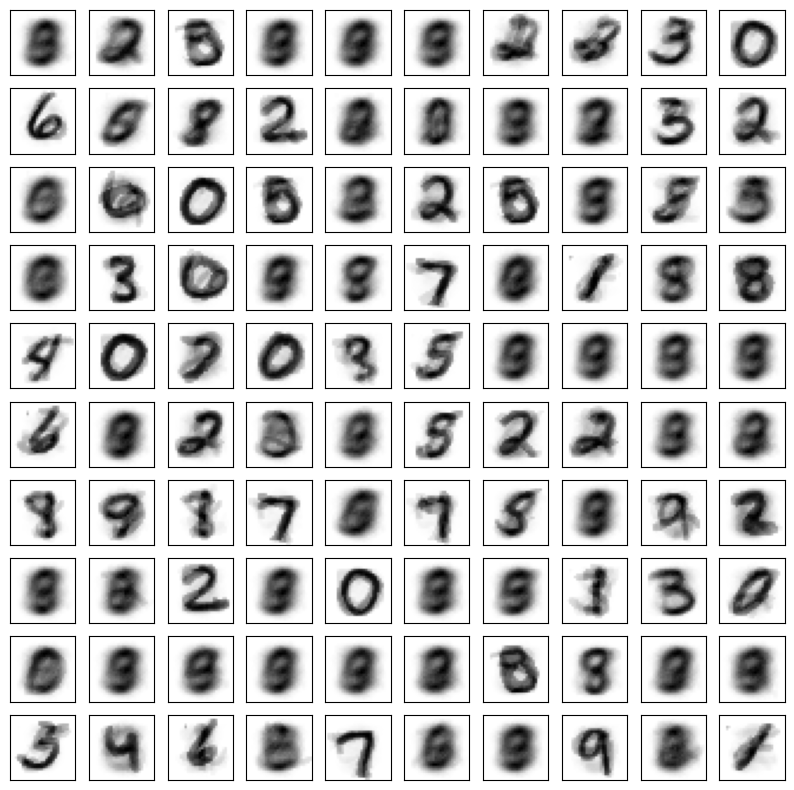

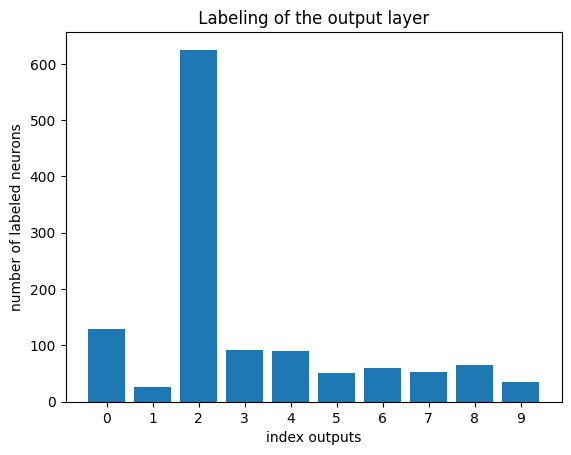

In [2]:

folder = '../data_backup/without_noise_final/example_analogSNN_trained'
with open(f'{folder}/weightfile_exci', 'rb') as file:
    weight_matrix_exci = pickle.load(file)
with open(f'{folder}/weightfile_inhi', 'rb') as file:
    weight_matrix_inhi = pickle.load(file)
with open(f'{folder}/weightfile_wta', 'rb') as file:
    weight_matrix_wta = pickle.load(file)
with open(f'{folder}/labelfile', 'rb') as file:
    labeled_neurons = pickle.load(file)
    

print("weight_matrix_exci.shape",weight_matrix_exci.shape)
print("weight_matrix_inhi.shape",weight_matrix_inhi.shape)
print("weight_matrix_wta.shape",weight_matrix_wta.shape)

weight_matrix_exci = weight_matrix_exci.T
weight_matrix_inhi = weight_matrix_inhi.T

weight_matrix_T = weight_matrix_exci
plt.figure(figsize=(10,10))
for u in range(10):
    for uu in range(10):
        ax = plt.subplot2grid((10,10),(u,uu))
        ax.imshow(weight_matrix_T[u*10+uu].reshape(28, 28), cmap=plt.cm.gray_r)
        plt.xticks([])
        plt.yticks([])
plt.show()

plt.figure()
redundancy_neuron = np.bincount(labeled_neurons, minlength=4)
bar(range(len(redundancy_neuron)),redundancy_neuron)
xticks(range(len(redundancy_neuron)))
plt.xlabel('index outputs')
plt.ylabel('number of labeled neurons')
plt.title(" Labeling of the output layer ")
plt.show()





## Evaluation of a trained eSNN

This code tests a pre-trained network

In [3]:
# Usuful function

def load_mnist(nb_train, nb_test, working_range=8, batch_size_train=256, batch_size_test=50):
    # Import the MNIST Database
    (X_train, y_train), (X_test, y_test) = mnist.load_data()


    # Make pixel intensity 255 become working_range*nA
    X_train = X_train * (working_range/255)
    X_test = X_test * (working_range/255)

    if nb_train >= len(X_train) or nb_train <= 0:
        nb_train = len(X_train)
    if nb_test >= len(X_test) or nb_test <= 0:
        nb_test = len(X_test)

    #Reduce the mnist-list for debbuging part
    X_train, X_test = X_train[:nb_train], X_test[:nb_test]
    y_train, y_test = y_train[:nb_train], y_test[:nb_test]
    
    X_train_batches, y_train_batches,X_test_batches, y_test_batches, nb_batch = shuffle_and_batch_data(X_train, y_train, X_test, y_test,batch_size_train,batch_size_test)
    
    return X_train_batches, y_train_batches, X_test_batches, y_test_batches,nb_batch



def shuffle_and_batch_data(X_train, y_train, X_test, y_test, batch_size_train,batch_size_test):
    # Combine the features and labels to shuffle them together
    combined_train = list(zip(X_train, y_train))
    np.random.shuffle(combined_train)
    X_train[:], y_train[:] = zip(*combined_train)
    
    combined_test = list(zip(X_test, y_test))
    np.random.shuffle(combined_test)
    X_test[:], y_test[:] = zip(*combined_test)
    
    # Calculate the total number of batches
    n_batches_train = len(X_train) // batch_size_train
    if len(X_train) % batch_size_train != 0:
        n_batches_train += 1
        
    # Calculate the total number of batches
    n_batches_test = len(X_test) // batch_size_test
    if len(X_test) % batch_size_test != 0:
        n_batches_test += 1
    
    # Divide the data into batches
    X_train_batches = np.array_split(np.array(X_train), n_batches_train)
    y_train_batches = np.array_split(np.array(y_train), n_batches_train)
    X_test_batches = np.array_split(np.array(X_test), n_batches_test)
    y_test_batches = np.array_split(np.array(y_test), n_batches_test)
    
    return X_train_batches, y_train_batches, X_test_batches, y_test_batches,n_batches_train


def reducing_list(original_list, new_size):
    '''
        Function that reduces the size of a list and lessen the amount of computation
    In input:
        - Original_list: list you want to reduce in size
        - new_size: size desired for the list
    It returns:
        - Similar list with desired size
    '''
    original_size = len(original_list)
    if new_size >= original_size:
        return original_list  

    # Calculate the sampling interval
    interval = original_size / new_size

    # Sample elements at regular intervals
    new_list = [original_list[int(i * interval)] for i in range(new_size)]

    return new_list


def extracting_eNeuron_behavior(csv_file_path,nb_point_interpolation):
    '''
        Function that extrates data from the transfer function of th eNeuron ML in order to define a linear-
        interpolation function
    In input:
        - path of the csv file containing the transfer function of the eNeuron
        - nb_point_interpolation: size of the interpolated list
    It returns:
        - i_new: x-axis of the interpolated function (amp)
        - f_new: y-axs of the interpolated function (Hz)
    '''

    input_current = []
    spike_rate = []

    # Open the CSV file
    with open(csv_file_path, 'r') as file:
        csv_reader = csv.reader(file, delimiter='\t')
        next(csv_reader)
        for row in csv_reader:
            values = re.split(r',', row[0])
            input_current.append(float(values[0]))
            spike_rate.append(float(values[1]))

    prefs.codegen.target = 'numpy'
    i_new = reducing_list(input_current,nb_point_interpolation)
    f_new = reducing_list(spike_rate,nb_point_interpolation)

    # Convert data to use with Brian2
    i_new = i_new * amp
    f_new = f_new * Hz
    
    return i_new, f_new


In [4]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()

# Simulation parameters
defaultclock.dt = 0.005*us  
time_per_sample = 100 * us
resting_time = 20 * us

# Defining the linear interpolation of the eNeuron ML behavior
i_new, f_new = extracting_eNeuron_behavior(csv_file_path='FT_augmented.csv',nb_point_interpolation=1111)
interp_function = interp1d(i_new, f_new, fill_value='extrapolate')

@check_units(x=amp, result = Hz)
def y_interp_function(x):
    return interp_function(x)*Hz

#Model parameters
v_rest = -80*mV
v_threshold = 60*mV  
v_std_thresh = 0*mV 
v_reset = -100*mV
v0 = -40*mV  
tau = 500*us
tau2 = 15*us
Rm = 5000*Mohm
I0=1*amp

a_v = 1126.6343973469338
b_v = 169200.45773494235
a_value = 6.23667974e13

x_threshold_v= 8.3e-11*amp
q, R_ds,C_m = 1.6*1e-19*amp*second, 5*ohm, 5*1e-8*second/ohm
avoid_error = 0.01*pA
frequency_min = 0.1*Hz
refrac = 0*us
alpha_e = 0.15
alpha_i = 0.04
beta_e = 1.9
beta_i = 0.5
avoid_error = 0.01*pA


# This model use a constant Resistance and a log approximation
neuron_eqs_v1 = '''
dv/dt =  (v_rest - v) / tau2 + (( int((I + Ie+I_inhi) > x_threshold_v) *((a_v + b_v * log((1-int((I + Ie+I_inhi) > x_threshold_v))+int((I + Ie+I_inhi) > x_threshold_v)*(I+Ie+I_inhi+avoid_error)/(x_threshold_v) ))*I0)/a_value)*Rm) / tau : volt (unless refractory)
Ie =  alpha_e*ge * uS *(80*mV -v)           : amp
I_inhi =  alpha_i*gi * uS *(-120*mV -v)           : amp
I : amp
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1

threshold = v_threshold + int(noise_activity)*v_std_thresh*randn() : volt (constant over dt)
noise_activity : boolean (shared) # (un)Activate the noise
'''

reset_eqs = '''
v = v_reset
'''



#STDP parameters
tau_stdp = 1.88116837
mag_stdp = 0.007070372048
mag_stdp = 0.002370372048


taupre = tau_stdp*us
taupost = taupre
wmax = 1
dApre = mag_stdp
dApost = -dApre * taupre / taupost * 1.05

stdp_eqs_exci = '''
    w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)
'''
pre_eqs_exci='''
    ge_post += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, wmax)
'''
post_eqs_exci='''
    Apost += dApost
    w = clip(w + lr*Apre, 0, wmax)
'''

stdp_eqs_inhi = '''
    w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)
'''
pre_eqs_inhi='''
    gi_post += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, wmax)
'''
post_eqs_inhi='''
    Apost += dApost
    w = clip(w + lr*Apre, 0, wmax)
'''

synapse_model = "w : 1"



n_input, n_output = 28*28,1225

class SNN_eNeuron():
    def __init__(self, debug=False):
        '''
            Initialization including setting up neuron groups and synapses
        '''

        from brian2 import clear_cache
        from brian2 import device
        device.reinit()
        start_scope()

        # Simulation parameters
        defaultclock.dt = 0.005*us  

        model = {}

        model['input'] = NeuronGroup(N=n_input, model=neuron_eqs_v1, threshold='v >= threshold', reset=reset_eqs, refractory='refrac', method='heun',name='input')
        model['input'].noise_activity = False

        model['output'] = NeuronGroup(N=n_output, model=neuron_eqs_v1, threshold='v >= threshold', reset=reset_eqs, refractory='refrac', method='heun',name='output')
        model['output'].noise_activity = False

        model['input_synapse_exci'] = Synapses(model['input'], model['output'], model=stdp_eqs_exci, on_pre=pre_eqs_exci, on_post=post_eqs_exci,name='input_synapse_exci')
        model['input_synapse_exci'].connect(True)
        model['input_synapse_exci'].w = weight_matrix_exci[model['input_synapse_exci'].j, model['input_synapse_exci'].i]
        model['input_synapse_exci'].delay = 'rand()*0*us'

        model['input_synapse_inhi'] = Synapses(model['input'], model['output'], model=stdp_eqs_inhi, on_pre=pre_eqs_inhi, on_post=post_eqs_inhi,name='input_synapse_inhi')
        model['input_synapse_inhi'].connect(True)
        model['input_synapse_inhi'].w = weight_matrix_inhi[model['input_synapse_inhi'].j, model['input_synapse_inhi'].i]
        model['input_synapse_inhi'].delay = 'rand()*0*us'

        model['wta_synapse'] = Synapses(model['output'], model['output'], model=synapse_model, on_pre='gi_post += w',name='wta_synapse')
        model['wta_synapse'].connect(condition='i != j')
        model['wta_synapse'].w = weight_matrix_wta
        model['wta_synapse'].delay = 'rand()*0*us'

        model['output_SP'] = SpikeMonitor(model['output'], record= False,name='output_SP')
        
        
        if (debug):
            model['input_SP'] = SpikeMonitor(model['input'], record=True,name='input_SP')
            model['output_SP'] = SpikeMonitor(model['output'], record=True,name='output_SP')

        print("You've created :",len(model['input_synapse_exci'])+len(model['input_synapse_inhi'])+len(model['wta_synapse']) , "synapses in your network \n \n")

        self.net = Network(model)
        
        self.weight_evol_exci = []
        self.weight_evol_inhi = []
        self.weight_epoch_exci = []
        self.weight_epoch_inhi= []


    def __getitem__(self,key):
        return self.net[key]

    
    def final_evaluation(self,X_test,y_test,noise=True,plot=False):
        '''
            Final evaluation post training: function that tests the trained network on test data and calculate accuracy
        '''
        # (un)Activate the noise
        self.net['input'].noise_activity = noise
        self.net['output'].noise_activity = noise

        # Desactivate STDP plasticity
        self.net['input_synapse_exci'].lr = 0
        self.net['input_synapse_inhi'].lr = 0
                
        spikes = np.zeros((10, n_output))

        old_spike_counts = np.zeros(n_output)
        old_spike_counts = np.copy(self.net['output_SP'].count)

        num_correct_output_max = 0
        confusion_matrix = np.zeros(100).reshape(10,10)
      
        for j, (sample, label) in enumerate(zip(X_test, y_test)):
            self.net['input'].I = sample.ravel() * nA
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            # Start the simulation
            self.net.run(time_per_sample)
            counter_spike = self.net['output_SP'].count - old_spike_counts
            spikes[int(label)] += counter_spike    
            
            # Prediction of the SNN post labelisation
            output_label_max = labeled_neurons[np.argmax(counter_spike)]

            # Check prediction of the class of the sample
            if j < 10:
                print("output_label_max = ", output_label_max, " and int(label) = ", int(label))
            if output_label_max == int(label):
                num_correct_output_max += 1
            confusion_matrix[int(label)][output_label_max] +=1
        
            # Allow the variables to return to their resting values
            self.net['input'].I = 0 * nA
            self.net.run(resting_time) 
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            old_spike_counts = np.copy(self.net['output_SP'].count)
            
            if j >= 10 and j<11 and plot:
                plt.figure(figsize=(20, 10)) 
                plt.plot(self.net['input_SP'].t/us, self.net['input_SP'].i, '.b',label='input')
                plt.plot(self.net['output_SP'].t/us, self.net['output_SP'].i, '.r',label='output')
                plt.ylabel('Neuron index')
                plt.xlabel('time (us)')
                plt.title("burst map")
                plt.legend()
                plt.show()


        accuracy_max = (num_correct_output_max / len(X_test))
        
        if plot:
            plt.figure()
            for i in range(len(spikes)):
                if spikes[i].any() != np.zeros(len(spikes[i])).any():
                    plt.plot(range(len(spikes[i])),spikes[i], label=f'label {i}')
            plt.ylabel('number of spikes')
            plt.xlabel('index of the output neurons')
            plt.title(" Spiking differenciation on the output layer ")
            plt.legend()
            plt.show()

        print(" \n \n accuracy_max = ",accuracy_max, " \n \n")
        return accuracy_max,confusion_matrix
    

You've created : 3420200 synapses in your network 
 

output_label_max =  7  and int(label) =  7
output_label_max =  3  and int(label) =  1
output_label_max =  3  and int(label) =  3
output_label_max =  9  and int(label) =  7
output_label_max =  4  and int(label) =  4
output_label_max =  7  and int(label) =  7
output_label_max =  9  and int(label) =  8
output_label_max =  9  and int(label) =  0
output_label_max =  1  and int(label) =  3
output_label_max =  3  and int(label) =  5


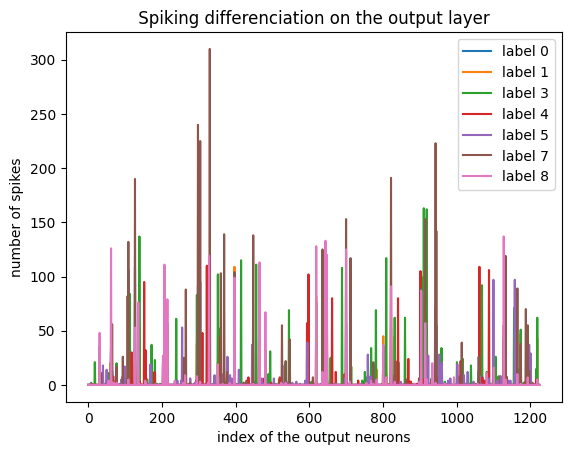

 
 
 accuracy_max =  0.4  
 


 accuracy_max =  0.4


In [5]:
debug = True
model = SNN_eNeuron(debug=debug) 

X_train_batches, y_train_batches, X_test_batches, y_test_batches, nb_batch = load_mnist(nb_train=300, nb_test=300, working_range=3, batch_size_train=10,batch_size_test=10)
accuracy_max,confusion_matrix = model.final_evaluation(X_test_batches[0], y_test_batches[0],noise=True,plot=debug)

print("\n accuracy_max = ", accuracy_max)

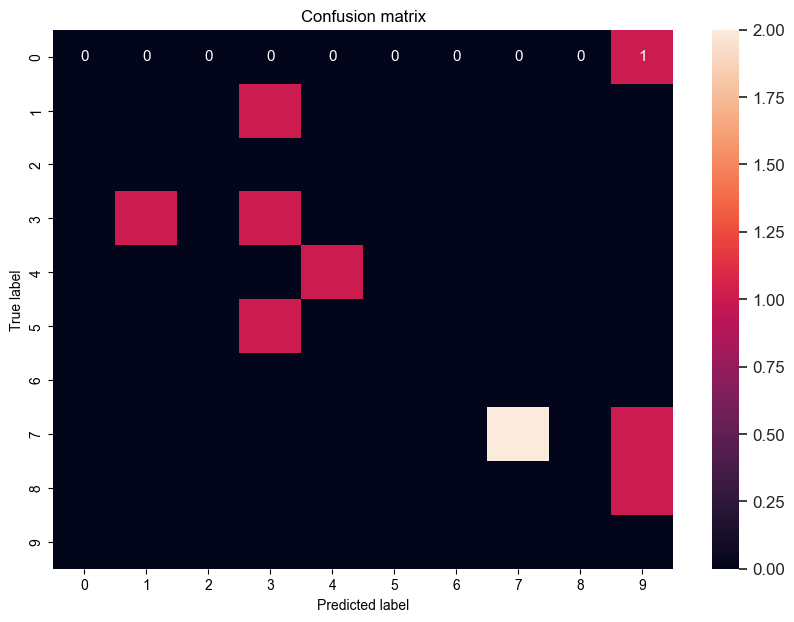

In [6]:
df_cm = pd.DataFrame(confusion_matrix, range(10), range(10))
plt.figure(figsize=(10,7))
plt.title("Confusion matrix")
sn.set(font_scale=1.1) # label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 11}) # font size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()